# <font color='blue'>Data Science Challenge @ ITA 2022</font>
# <font color='blue'>Equipe DIOMGIS</font>

## <font color='blue'>2º Fase</font>

### <font color='blue'>Construção de carteira composta por ativos que compõem o índice SP500.</font>

![title](data\image\logo.jpeg)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [2]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# Bibliotecas e Frameworks

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime
from hurst import compute_Hc, random_walk
from pykalman import KalmanFilter
from statsmodels.tsa.seasonal import STL

from sklearn.cluster import KMeans

In [4]:
# Versões dos pacotes usados neste jupyter notebook

%reload_ext watermark
%watermark -a "Equipe DIOMGIS" --iversions

Author: Equipe DIOMGIS

pandas_datareader: 0.10.0
matplotlib       : 3.5.1
pandas           : 1.4.2
seaborn          : 0.11.2
numpy            : 1.22.3



In [5]:
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams['figure.figsize'] = (15, 10)

In [6]:
# Parametros fixos de treinamento

quantAtivos = 10
verbose = 2
seed = 25
epochs = 2000
downloadData = False

np.random.seed(seed)

In [7]:
setores = {
    'Industrials': ['MMM', 'AOS', 'ALK', 'ALLE', 'AAL', 'AME', 'BA',
                    'CHRW', 'CARR', 'CAT', 'CTAS', 'CPRT', 'CSGP',
                    'CSX', 'CMI', 'DE', 'DAL', 'DOV', 'ETN', 'EMR',
                    'EFX', 'EXPD', 'FAST', 'FDX', 'FTV', 'FBHS',
                    'GNRC', 'GD', 'GE', 'HON', 'HWM', 'HII', 'IEX',
                    'ITW', 'IR', 'JBHT', 'J', 'JCI', 'LHX', 'LDOS',
                    'LMT', 'MAS', 'NDSN', 'NSC', 'NOC', 'ODFL',
                    'OTIS', 'PCAR', 'PH', 'PNR', 'PWR', 'RTX', 'RSG',
                    'RHI', 'ROK', 'ROL', 'SNA', 'LUV', 'SWK', 'TXT',
                    'TT', 'TDG', 'UNP', 'UAL', 'UPS', 'URI', 'VRSK',
                    'WAB', 'WM', 'GWW', 'XYL'],
    
    'HealthCare': ['ABT', 'ABBV', 'ABMD', 'A', 'ALGN', 'ABC', 'AMGN',
                   'BAX', 'BDX', 'BIO', 'TECH', 'BIIB', 'BSX', 'BMY',
                   'CAH', 'CTLT', 'CNC', 'CRL', 'CI', 'COO', 'CVS',
                   'DHR', 'DVA', 'XRAY', 'DXCM', 'EW', 'ELV', 'LLY',
                   'GILD', 'HCA', 'HSIC', 'HOLX', 'HUM', 'IDXX',
                   'ILMN', 'INCY', 'ISRG', 'IQV', 'JNJ', 'LH', 'MCK',
                   'MDT', 'MRK', 'MTD', 'MRNA', 'MOH', 'OGN', 'PKI',
                   'PFE', 'DGX', 'REGN', 'RMD', 'STE', 'SYK', 'TFX',
                   'TMO', 'UNH', 'UHS', 'VRTX', 'VTRS', 'WAT',
                   'WST', 'ZBH', 'ZTS'],
    
    'InformationTechnology': ['ACN', 'ADBE', 'ADP', 'AKAM', 'AMD', 'APH',
                              'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET', 'ADSK',
                              'AVGO', 'BR', 'CDNS', 'CDW', 'CDAY', 'CSCO',
                              'CTSH', 'GLW', 'DXC', 'ENPH', 'EPAM', 'FFIV',
                              'FIS', 'FISV', 'FLT', 'FTNT', 'IT', 'GPN',
                              'HPE', 'HPQ', 'IBM', 'INTC', 'INTU', 'JKHY',
                              'JNPR', 'KEYS', 'KLAC', 'LRCX', 'MA', 'MCHP',
                              'MU', 'MSFT', 'MPWR', 'MSI', 'NTAP', 'NLOK',
                              'NVDA', 'NXPI', 'ON', 'ORCL', 'PAYX', 'PAYC',
                              'PYPL', 'PTC', 'QRVO', 'QCOM', 'ROP', 'CRM',
                              'STX', 'NOW', 'SWKS', 'SEDG', 'SNPS', 'TEL',
                              'TDY', 'TER', 'TXN', 'TRMB', 'TYL', 'VRSN',
                              'V', 'WDC', 'ZBRA'],
    
    'CommunicationServices': ['ATVI', 'GOOGL', 'GOOG', 'T', 'CHTR', 'CMCSA',
                              'DISH', 'DIS', 'EA', 'FOXA', 'FOX', 'IPG', 'LYV',
                              'LUMN', 'MTCH', 'META', 'NFLX', 'NWSA', 'NWS',
                              'OMC', 'PARA', 'TMUS', 'TTWO', 'TWTR', 'VZ', 'WBD'],
    
    'ConsumerStaples': ['ADM', 'MO', 'BF.B', 'CPB', 'CHD', 'CLX', 'KO', 'CL',
                        'CAG', 'STZ', 'COST', 'EL', 'GIS', 'HSY', 'HRL', 'K',
                        'KDP', 'KMB', 'KHC', 'KR', 'LW', 'MKC', 'TAP', 'MDLZ',
                        'MNST', 'PEP', 'PM', 'PG', 'SJM', 'SYY', 'TSN', 'WBA',
                        'WMT'],
    
    'ConsumerDiscretionary': ['AAP', 'AMZN', 'APTV', 'AZO', 'BBWI',
                              'BBY', 'BKNG', 'BWA', 'CZR', 'KMX', 'CCL',
                              'CMG', 'DHI', 'DRI', 'DG', 'DLTR',
                              'DPZ', 'EBAY', 'ETSY', 'EXPE', 'F',
                              'GRMN', 'GM', 'GPC', 'HAS', 'HLT', 'HD',
                              'LVS', 'LEN', 'LKQ', 'LOW', 'MAR', 'MCD',
                              'MGM', 'MHK', 'NWL', 'NKE', 'NCLH', 'NVR',
                              'ORLY', 'POOL', 'PHM', 'RL', 'ROST', 'RCL',
                              'SBUX', 'TPR', 'TGT', 'TSLA', 'TJX',
                              'TSCO', 'ULTA', 'VFC', 'WHR', 'WYNN', 'YUM'],
    
    'Utilities': ['AES', 'LNT', 'AEE', 'AEP', 'AWK', 'ATO', 'CNP',
                  'CMS', 'ED', 'CEG', 'D', 'DTE', 'DUK', 'EIX',
                  'ETR', 'EVRG', 'ES', 'EXC', 'FE', 'NEE', 'NI',
                  'NRG', 'PCG', 'PNW', 'PPL', 'PEG', 'SRE', 'SO',
                  'WEC', 'XEL'],
    
    'Financials': ['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'AJG',
                   'AIZ', 'BAC', 'WRB', 'BRK.B', 'BLK', 'BK', 'BRO',
                   'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG',
                   'CME', 'CMA', 'DFS', 'RE', 'FDS', 'FITB', 'FRC',
                   'BEN', 'GL', 'GS', 'HIG', 'HBAN', 'ICE', 'IVZ',
                   'JPM', 'KEY', 'LNC', 'L', 'MTB', 'MKTX', 'MMC',
                   'MET', 'MCO', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PNC',
                   'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'SBNY',
                   'STT', 'SIVB', 'SYF', 'TROW', 'TRV', 'TFC',
                   'USB', 'WFC', 'WTW', 'ZION',  'NLSN'],
    
    'Materials': ['APD', 'ALB', 'AMCR', 'AVY', 'BALL', 'CE', 'CF',
                  'CTVA', 'DOW', 'DD', 'EMN', 'ECL', 'FMC', 'FCX',
                  'IP', 'IFF', 'LIN', 'LYB', 'MLM', 'MOS', 'NEM',
                  'NUE', 'PKG', 'PPG', 'SEE', 'SHW', 'VMC', 'WRK'],
    
    'RealEstate': ['ARE', 'AMT', 'AVB', 'BXP', 'CPT', 'CBRE', 'CCI',
                   'DLR', 'EQIX', 'EQR', 'ESS', 'EXR', 'FRT', 'PEAK',
                   'HST', 'INVH', 'IRM', 'KIM', 'MAA', 'PLD', 'PSA',
                   'O', 'REG', 'SBAC', 'SPG', 'UDR', 'VTR', 'VICI',
                   'VNO', 'WELL', 'WY'],
    
    'Energy': ['APA','BKR', 'CVX', 'COP', 'CTRA', 'DVN', 'FANG', 'EOG',
               'EQT', 'XOM', 'HAL', 'HES', 'KMI', 'MRO', 'MPC', 'OXY',
               'OKE', 'PSX', 'PXD', 'SLB', 'VLO', 'WMB']
}

In [8]:
ativos = []
for setor, empresas in setores.items():
    ativos.extend(empresas)
    
ativos.sort()

### Download dos Dados

In [9]:
if downloadData:

    start_date = "2017-10-21"
    end_date = "2022-10-21"

    data = web.DataReader(name = '^GSPC', data_source = 'yahoo', start = start_date, end = end_date)
    SP500_index = pd.DataFrame(data['Close']).reset_index().rename(columns={'Close': 'SP500', 'Date': 'Dia'})

    SP500_close = pd.DataFrame()

    for ativo in ativos:
  
        if ativo == 'BF.B':
            ativo = 'BF-B'

        if ativo == 'BRK.B':
            ativo = 'BRK-B'

        data = web.DataReader(name = ativo, data_source = 'yahoo', start = start_date, end = end_date)
        temp_close = pd.DataFrame(data['Close'])
        SP500_close = pd.concat([SP500_close, temp_close], axis = 1)

        
    SP500_close.columns = ativos
    SP500_close.reset_index(inplace = True)
    SP500_close.rename(columns={'Date': 'Dia'}, inplace = True)

    outdir = './data/{}-{}'.format(start_date, end_date)

    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    SP500_close.to_csv(path_or_buf = os.path.join(outdir, 'SP500_close'), index = False)
    SP500_index.to_csv(path_or_buf = os.path.join(outdir, 'SP500_index'), index = False)
    
else:
    SP500_close = pd.read_csv('./data/train/SP500Close.csv')
    SP500_close = SP500_close.set_index("Dia")
    SP500_close.index = pd.to_datetime(SP500_close.index)
    SP500_index = pd.read_csv('./data/train/SP500Index.csv')
    SP500_index = SP500_index.set_index("Dia")
    SP500_index.index = pd.to_datetime(SP500_index.index)

## Pré-Processamento dos Dados

In [10]:
df = SP500_close.copy()

In [11]:
df.isna().any().sum()

11

In [12]:
df = df.fillna(method = 'backfill', axis = 'columns')

In [13]:
df.isna().any().sum()

0

In [14]:
scaler = StandardScaler()

In [15]:
scaler.fit(df)

StandardScaler()

In [16]:
dfScalerNP = scaler.transform(df)

In [17]:
dfScaled = pd.DataFrame(dfScalerNP, columns = df.columns, index = df.index)

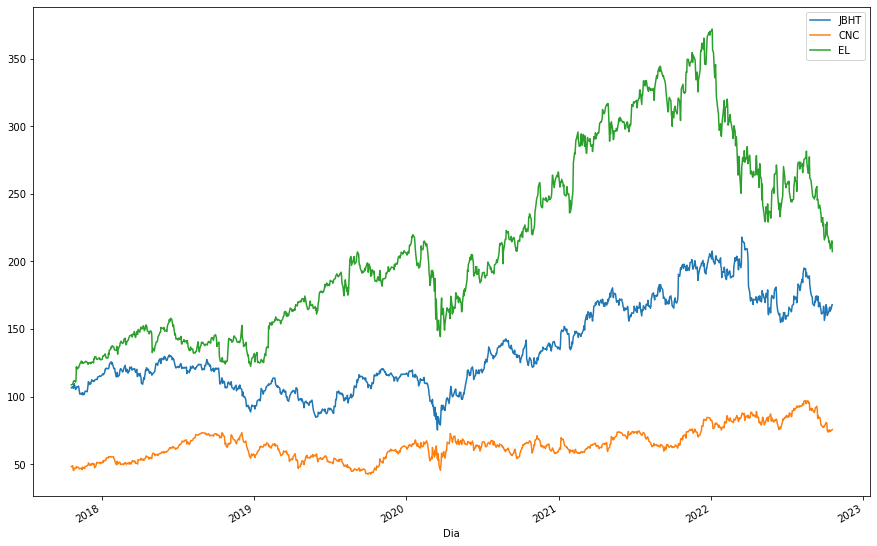

In [18]:
df.T.sample(3, random_state = 11).T.plot();

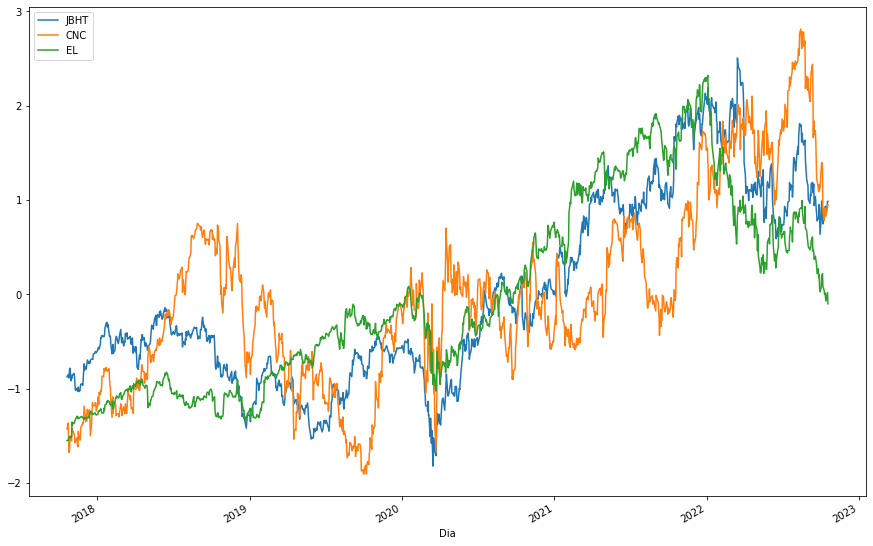

In [19]:
dfScaled.T.sample(3, random_state = 11).T.plot();

In [20]:
kmeans = KMeans(n_clusters = quantAtivos,
                n_init = 10 ,
                max_iter = 300,
                tol = 0.0001,
                verbose = 2,
                random_state = seed,
                algorithm = 'lloyd') # “lloyd”, “elkan”

In [21]:
kmeans.fit(dfScalerNP.T)

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Initialization complete
Iteration 0, inertia 223304.02309000143.
Iteration 1, inertia 161207.7686857513.
Iteration 2, inertia 157096.8492693407.
Iteration 3, inertia 154668.11554266568.
Iteration 4, inertia 152252.59346701545.
Iteration 5, inertia 150210.78897168813.
Iteration 6, inertia 149240.9483808259.
Iteration 7, inertia 148856.640834283.
Iteration 8, inertia 148623.18511820337.
Iteration 9, inertia 148532.6483790598.
Iteration 10, inertia 148489.64352750208.
Iteration 11, inertia 148477.23112367676.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 220084.99707543675.
Iteration 1, inertia 159951.411297472.
Iteration 2, inertia 156694.92003636126.
Iteration 3, inertia 155230.2494602903.
Iteration 4, inertia 154293.61337524102.
Iteration 5, inertia 153401.22008268785.
Iteration 6, inertia 152870.6285439133.
Iteration 7, inertia 152463.13096136696.
Iteration 8, inertia 151888.68485340415.
Iteration 9, inertia 151173.42154231062.
Iteration 1

KMeans(n_clusters=10, random_state=25, verbose=2)

In [22]:
selectGroup = []
ativosGroup = []
meanGroup = []
columns = []

for i in range(quantAtivos):
    columns.append('Grupo {}'.format(i))

for group in np.unique(kmeans.labels_, return_counts=True)[0]:
    filter = kmeans.labels_ == group
    selectGroup.append(filter)
    ativosGroup.append(dfScaled.T[filter].index)
    meanGroup.append(dfScaled.T[filter].mean())
    
    
setorGroups = pd.DataFrame(np.zeros(shape = (len(setores), len(selectGroup)), dtype = int),
                           index = setores.keys(),
                           columns = columns)
    
for group in range(len(ativosGroup)):
    for ativo in ativosGroup[group]:
        for setor in setores.keys():
            if ativo in setores[setor]:
                setorGroups.loc[setor, setorGroups.columns[group]] += 1


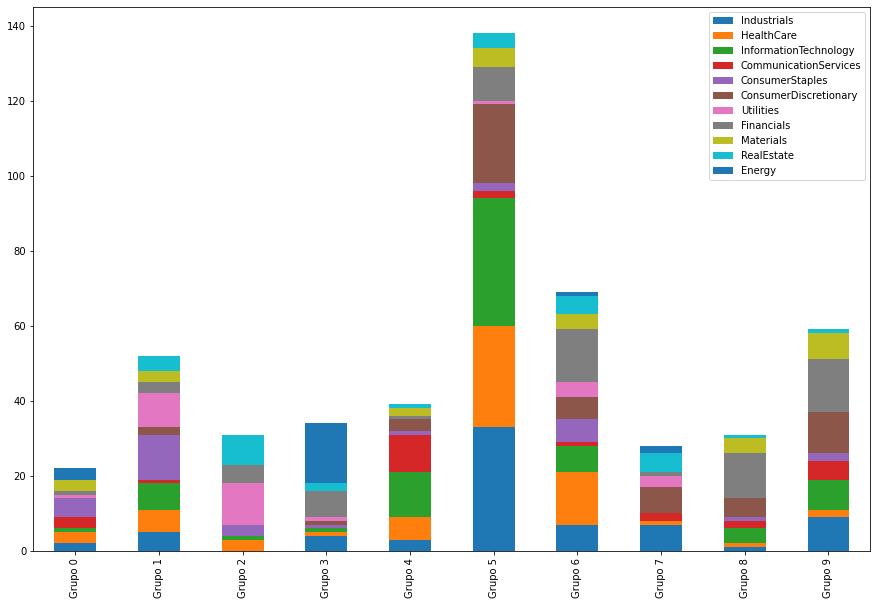

In [23]:
setorGroups.T.plot.bar(stacked=True);

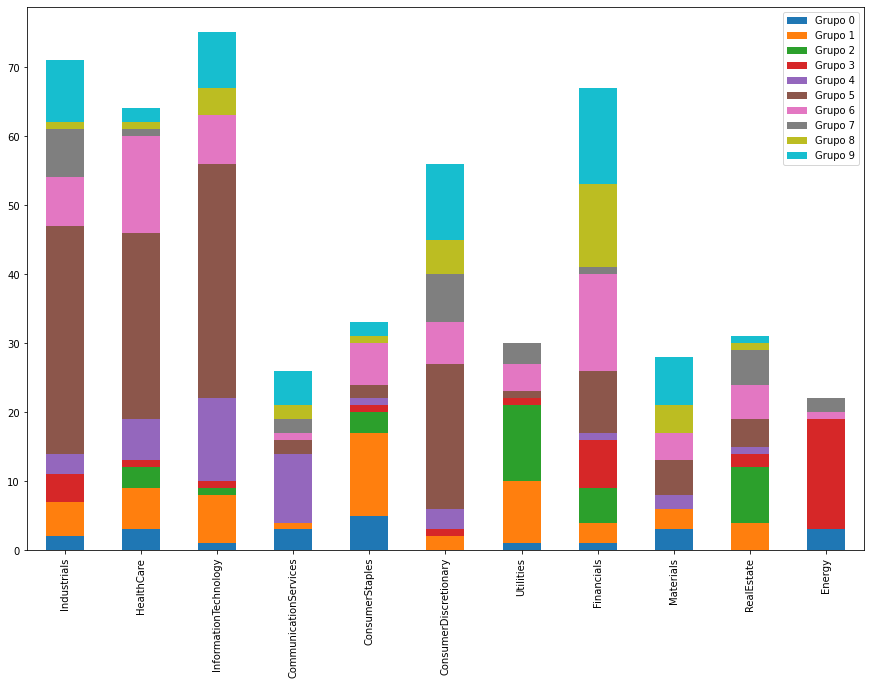

In [24]:
setorGroups.plot.bar(stacked=True);

In [25]:
mediaDF = pd.DataFrame(index = columns, columns = ["H", "c"])

In [33]:
sns.set_style("darkgrid")

time = datetime.now().strftime('%d-%B-%Ih%Mmin')
SP500IndexPct = SP500_index.pct_change().dropna()['SP500']

obs_matriz = np.expand_dims(np.vstack([[SP500IndexPct],
                                       [np.ones(len(SP500IndexPct))]]).T, axis = 1)

kf = KalmanFilter(initial_state_mean = [0, 0],
                  initial_state_covariance = np.ones((2, 2)),
                  transition_matrices = np.eye(2),
                  observation_matrices = obs_matriz)

outdir = './graphics/2º Fase/{}'.format(time)
if not os.path.exists(outdir):
    os.mkdir(outdir)

for group in range(quantAtivos):
    H, c, data = compute_Hc(meanGroup[group].to_numpy() + 10, kind='price', simplified=True)
    '''
    f, ax = plt.subplots()
    ax.plot(data[0], c*data[0]**H, color="deepskyblue")
    ax.scatter(data[0], data[1], color="purple")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Time interval')
    ax.set_ylabel('R/S ratio')
    ax.grid(True)
    plt.show()
    '''
    
    mediaDF.loc[mediaDF.index[group], "H"] = H
    mediaDF.loc[mediaDF.index[group], "c"] = c
    
    stateMeans, stateCovs = kf.filter(meanGroup[group].pct_change().dropna())

    fig, ax = plt.subplots()
    ax.plot(SP500IndexPct.index, stateMeans[:, 0])
    ax.set_title("GRUPO {}".format(group))
    ax.set(xlabel='Data', ylabel = 'Coeficiente Beta')
    nameGraphic = '{} Coeficiente Beta.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
    
    stl = STL(meanGroup[group], period=365).fit()
    
    fig = stl.plot()
    ax.set_title("GRUPO {}".format(group))
    nameGraphic = '{} STL.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
       
    fig, ax = plt.subplots()
    dfScaled.T[selectGroup[group]].T.plot(ax = ax)
    ax.set_title("GRUPO {}".format(group))
    ax.set(xlabel='Data', ylabel='Preço Normalizado($)')
    nameGraphic = '{} Grupo.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
    
    fig, ax = plt.subplots()
    meanGroup[group].plot(ax = ax)
    ax.set_title("MEDIA GRUPAL {} / Expoente de Hurst: {:.3f}".format(group, H))
    ax.set(xlabel='Data', ylabel='Preço Normalizado($)')
    nameGraphic = '{} Media Grupal.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
#------------------------------------------------------------------------------------------------------------

In [34]:
mediaDF

,H,c
Grupo 0,0.653331,0.841195
Grupo 1,0.544058,1.158064
Grupo 2,0.545093,1.158277
Grupo 3,0.60127,1.022439
Grupo 4,0.548123,1.170013
Grupo 5,0.632031,0.963817
Grupo 6,0.613852,0.961369
Grupo 7,0.560486,1.113059
Grupo 8,0.586257,1.089696
Grupo 9,0.619331,0.979343
